## Модуль Б.  Разведочный анализ данных

#### Импортирование библиотек

In [2]:
import pandas as pd
import io
import glob
import re
import nltk
import matplotlib.pyplot as plt
import pymorphy2
import fitz
import string
import numpy as np
import re
import pyLDAvis
import pyLDAvis.gensim
from nltk.stem import *
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm, trange
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
from __future__ import division
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns

### 1.2 Формирование структуры набора данных

### Описание структуры данных

__TitleCompany__ - Название компании

__TextPostLemat__ - обработанный, лематизированный текст 

__TextPostToken__ - обработанный, токенизированный и лематизированный текст (лематизирован другим способом нежели TextPostLemat)

__bigram__ - биграммы обработанного и лематизированного текста

__trigram__ - триграммы обработанного и лематизированного текста

__keyword__ - ключевые слова обработанного и лематизированного текста

__clustersAgglomerative__ - кластеры, образованные моделью Agglomerative

__clustersKmeans__ - кластеры, образованные моделью Kmeans

__clustersSpectral__ - кластеры, образованные моделью Spectral

#### Установка библиотек

### 2.1 Поиск ключевых слов/n-грамм. Векторизация текстов

In [3]:
dfHabr1 = pd.read_csv(r'Report1.csv')

In [4]:
mystem = Mystem() 
# добавление стопслов
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'быть', 'r', 'n', 'а', 'мы', 'с', 'для', 'ещё', 'его', 'также', 'к', 'тем', 'кто', 'чтобы', 'но', 'они', 'будут', 'так', 'где', 'один', 'он ', 'и', 'на', 'но', 'или', 'либо', 'это', 'мб', 'далее', 'дв', 'свой', 'ваш','всё', 'очень', 'её', 'ещё', 'вообще', 'наш', 'который'])

Из-за проблем с чтением нужно заново токенизировать текст, именно поэтому заново прописываю метод токенизации на лемматизированном тексте

In [86]:
dfHabr1.head(37)

,TitleCompany,TextPost,TextPostLemat,TextPostToken,bigram,trigram,keyword,clustersAgglomerative,clustersKmeans,clustersSpectral
0,Нетология,Многие из нас ежедневно пользуются поисковыми...,многие ежедневно пользоваться поисковый систем...,"[многие, ежедневно, пользоваться, поисковый, с...","[(многие, ежедневно), (ежедневно, пользоваться...","[(многие, ежедневно, пользоваться), (ежедневно...","человек, язык, компьютерный, текст, лингвистик...",2,1,0
1,Gett,"Всем привет, меня зовут Антон Тупиков, я – ти...",привет звать антон тупик тимлид команда просто...,"[привет, звать, антон, тупик, тимлид, команда,...","[(привет, звать), (звать, антон), (антон, тупи...","[(привет, звать, антон), (звать, антон, тупик)...","сервис, год, поездка, решение, клиент, каждый,...",0,2,0
2,Gett,"Привет! Меня зовут Виталий Костоусов, я работ...",привет звать виталий костоусов работать команд...,"[привет, звать, виталий, костоусов, работать, ...","[(привет, звать), (звать, виталий), (виталий, ...","[(привет, звать, виталий), (звать, виталий, ко...","проблема, сервис, работать, работа, команда, м...",0,2,0
3,Gett,"Всем привет, меня зовут Лера Лисичкина, я рук...",привет звать лера лисичкин руководить технолог...,"[привет, звать, лера, лисичкин, руководить, те...","[(привет, звать), (звать, лера), (лера, лисичк...","[(привет, звать, лера), (звать, лера, лисичкин...","команда, рассказывать, разработка, начинать, р...",0,2,0
4,Gett,"Всем привет, меня зовут Антон Тупиков, я – ти...",привет звать антон тупик тимлид команда просто...,"[привет, звать, антон, тупик, тимлид, команда,...","[(привет, звать), (звать, антон), (антон, тупи...","[(привет, звать, антон), (звать, антон, тупик)...","сервис, год, поездка, решение, клиент, каждый,...",0,2,0
5,Gett,"Привет! Меня зовут Виталий Костоусов, я работ...",привет звать виталий костоусов работать команд...,"[привет, звать, виталий, костоусов, работать, ...","[(привет, звать), (звать, виталий), (виталий, ...","[(привет, звать, виталий), (звать, виталий, ко...","проблема, сервис, работать, работа, команда, м...",0,2,0
6,Иннотех,"Привет, Хабр, мы — Иннотех. Если говорить офи...",привет хабр иннотеха говорить официально созда...,"[привет, хабр, иннотеха, говорить, официально,...","[(привет, хабр), (хабр, иннотеха), (иннотеха, ...","[(привет, хабр, иннотеха), (хабр, иннотеха, го...","год, иннотеха, компания, сотрудник, создавать,...",0,2,0
7,Иннотех,В тестировании я работаю около 5 лет. За это ...,тестирование работать около год время сменить ...,"[тестирование, работать, около, год, время, см...","[(тестирование, работать), (работать, около), ...","[(тестирование, работать, около), (работать, о...","стресс, фактор, задача, команда, работа, тести...",0,2,0
8,Иннотех,Analyst Days/14 — это международная конференц...,международный конференция системный бизнес ана...,"[международный, конференция, системный, бизнес...","[(международный, конференция), (конференция, с...","[(международный, конференция, системный), (кон...","доклад, аналитик, вопрос, конференция, задача,...",0,2,0
9,Иннотех,Поговорим о метриках тестирования: какие из н...,поговорить метрика тестирование наиболее эффек...,"[поговорить, метрика, тестирование, наиболее, ...","[(поговорить, метрика), (метрика, тестирование...","[(поговорить, метрика, тестирование), (метрика...","метрика, тестирование, кейс, процесс, тестовый...",0,2,0


In [8]:
def tokenize(text):
    t = word_tokenize(text)
    return [token for token in t if token not in russian_stopwords]

In [9]:
morph = pymorphy2.MorphAnalyzer()

C:\Users\essww\anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\essww\anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\essww\anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\essww\anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, def

In [10]:
# обработка текста токенизацией
prep_text1 = [tokenize(text.lower()) for text in tqdm(dfHabr1['TextPostLemat']) if text not in russian_stopwords]

  0%|          | 0/38 [00:00<?, ?it/s]

In [11]:
dfHabr1['TextPostToken'] = prep_text1

In [12]:
dfHabr1['bigram'] = ''
dfHabr1['trigram'] = ''
dfHabr1['keyword'] = ''

#### Создание биграммы, триграммы и ключевых слов, а также добавления их в датафрейм

In [13]:
# использование цикла с записью биграмм в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    dfHabr1['bigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 2))
# использование цикла с записью триграмм в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    dfHabr1['trigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 3))
# использование цикла с записью ключевых слов в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    freq_dist = nltk.FreqDist(dfHabr1['TextPostToken'][i])
    top_words = [word for word, count in freq_dist.most_common(10)]
    dfHabr1['keyword'][i] = ', '.join(top_words)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

In [161]:
dfHabr1.head(10)

,TitleCompany,TextPost,TextPostLemat,TextPostToken,bigram,trigram,keyword,clustersAgglomerative,clustersKmeans,clustersSpectral
0,Нетология,Многие из нас ежедневно пользуются поисковыми...,многие ежедневно пользоваться поисковый систем...,"[многие, ежедневно, пользоваться, поисковый, с...","[(многие, ежедневно), (ежедневно, пользоваться...","[(многие, ежедневно, пользоваться), (ежедневно...","человек, язык, компьютерный, текст, лингвистик...",0,0,1
1,Gett,"Всем привет, меня зовут Антон Тупиков, я – ти...",привет звать антон тупик тимлид команда просто...,"[привет, звать, антон, тупик, тимлид, команда,...","[(привет, звать), (звать, антон), (антон, тупи...","[(привет, звать, антон), (звать, антон, тупик)...","сервис, год, поездка, решение, клиент, каждый,...",0,1,1
2,Gett,"Привет! Меня зовут Виталий Костоусов, я работ...",привет звать виталий костоусов работать команд...,"[привет, звать, виталий, костоусов, работать, ...","[(привет, звать), (звать, виталий), (виталий, ...","[(привет, звать, виталий), (звать, виталий, ко...","проблема, сервис, работать, работа, команда, м...",2,1,1
3,Gett,"Всем привет, меня зовут Лера Лисичкина, я рук...",привет звать лера лисичкин руководить технолог...,"[привет, звать, лера, лисичкин, руководить, те...","[(привет, звать), (звать, лера), (лера, лисичк...","[(привет, звать, лера), (звать, лера, лисичкин...","команда, рассказывать, разработка, начинать, р...",0,0,1
6,Иннотех,"Привет, Хабр, мы — Иннотех. Если говорить офи...",привет хабр иннотеха говорить официально созда...,"[привет, хабр, иннотеха, говорить, официально,...","[(привет, хабр), (хабр, иннотеха), (иннотеха, ...","[(привет, хабр, иннотеха), (хабр, иннотеха, го...","год, иннотеха, компания, сотрудник, создавать,...",0,2,1
7,Иннотех,В тестировании я работаю около 5 лет. За это ...,тестирование работать около год время сменить ...,"[тестирование, работать, около, год, время, см...","[(тестирование, работать), (работать, около), ...","[(тестирование, работать, около), (работать, о...","стресс, фактор, задача, команда, работа, тести...",2,1,1
8,Иннотех,Analyst Days/14 — это международная конференц...,международный конференция системный бизнес ана...,"[международный, конференция, системный, бизнес...","[(международный, конференция), (конференция, с...","[(международный, конференция, системный), (кон...","доклад, аналитик, вопрос, конференция, задача,...",2,1,1
9,Иннотех,Поговорим о метриках тестирования: какие из н...,поговорить метрика тестирование наиболее эффек...,"[поговорить, метрика, тестирование, наиболее, ...","[(поговорить, метрика), (метрика, тестирование...","[(поговорить, метрика, тестирование), (метрика...","метрика, тестирование, кейс, процесс, тестовый...",2,1,1
10,Иннотех,Российский рынок труда для IT-специалистов вн...,российский рынок труд специалист вновь оживлят...,"[российский, рынок, труд, специалист, вновь, о...","[(российский, рынок), (рынок, труд), (труд, сп...","[(российский, рынок, труд), (рынок, труд, спец...","ответ, кандидат, вопрос, процесс, собеседовани...",2,1,1
11,Нетология,Алексей Скорик из Vinci Agency специально для...,алексей скорик специально блог нетология рассп...,"[алексей, скорик, специально, блог, нетология,...","[(алексей, скорик), (скорик, специально), (спе...","[(алексей, скорик, специально), (скорик, специ...","пользователь, продукт, интерфейс, работа, весь...",0,1,1


In [162]:
# метод препроцессинга, необходимый для полной очистки всего ненужного
def preprocess_text(data, stopwords=russian_stopwords):
    text = re.sub('ё','е', data.lower())
    text = text.strip()
    text = [w for w in text.split() if w not in stopwords] 
    text = [w for w in text if len(w) >=3]
    return ' '.join(text)

In [96]:
# вызов препроцессинга и трансформация
def transform_data(data: pd.Series) -> list:
    result = [preprocess_text(data=i) for i in data]
    return result

In [97]:
text = dfHabr1['keyword']

In [98]:
%%time
dfHabr2 = transform_data(text)

CPU times: total: 0 ns
Wall time: 1.32 ms


In [99]:
len(dfHabr2)

36

#### Векторизация текста, для дальнейшей обработки

In [100]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=1)
count_matrix = vectorizer.fit_transform(dfHabr2)

In [101]:
count_matrix.toarray()[:2,:200]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 

In [102]:
count_matrix.shape

(36, 808)

In [103]:
vectorizer.get_feature_names_out()[:50]

array(['автор', 'автор крышесносный', 'анализ', 'анализ первый',
       'анализ первый нетология', 'аналитик', 'аналитик вопрос',
       'аналитик вопрос конференция', 'аналитик курс',
       'аналитик курс продукт', 'аналитик обучение',
       'аналитик обучение октябрь', 'аналитик системный',
       'аналитик системный подойдт', 'аналитик тестовый',
       'аналитик часть', 'аналитик часть студент', 'аналитика',
       'аналитика проект', 'арт', 'арт креативный', 'банковский',
       'банковский город', 'банковский город хакатон', 'бесплатный',
       'бесплатный нетология', 'бесплатный нетология первый',
       'бесплатный развивать', 'бесплатный развивать обучение', 'бизнес',
       'бизнес арт', 'бизнес арт креативный', 'бизнес интернет',
       'бизнес интернет продукт', 'бизнес образование',
       'бизнес образование занятие', 'бизнес сотрудник',
       'бизнес сотрудник работать', 'бизнес цифровой',
       'бизнес цифровой магистратура', 'блог', 'вакансия',
       'вакансия ре

In [104]:
len(vectorizer.get_feature_names_out())

808

### 2.3 Кластеризация

Agglomerative - это метод кластеризации, который относится к иерархической кластеризации. Он работает путем объединения каждого отдельного кластера с процессом, который повторяется до тех пор, пока все кластеры не будут объединены в один кластер. Также полезен в случаях, когда нужно разбить данные на группы на основе их сходства.

In [105]:
# Выбор и применение алгоритма кластеризации
agg = AgglomerativeClustering(n_clusters=3).fit(count_matrix.toarray())

In [106]:
# Получение меток кластеров
labelsAgglomerative = agg.labels_
clusters1 = agg.labels_.tolist()

In [107]:
agg.labels_

array([0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2,
       1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [108]:
dfHabr1['clustersAgglomerative'] = clusters1

Kmeans - это метод кластеризации, который относится к семейству неконтролируемого обучения. Он используется для разбиения данных на группы на основе их сходства. Алгоритм начинается с выбора случайных центров кластеров, затем каждая точка данных присваивается к ближайшему центру кластера. Затем центры кластеров пересчитываются на основе точек данных, которые были присвоены кластеру, и процесс повторяется до тех пор, пока центры кластеров не стабилизируются. Также полезен в случаях, когда нужно разбить данные на группы на основе их сходства. 

In [109]:
# Метод к-средних - KMeans
km = KMeans(n_clusters=3).fit(count_matrix.toarray())

C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [110]:
labelsKmeans = km.labels_
clusters2 = km.labels_.tolist()

In [111]:
dfHabr1['clustersKmeans'] = clusters2

Spectral - это метод кластеризации, который использует линейную алгебру для разбиения данных на группы на основе их сходства. Он преобразует данные в новое пространство признаков, где они могут быть более легко разделены на группы. Затем он использует методы кластеризации, такие как K-means, для разбиения данных на группы. Spectral может быть полезен в случаях, когда нужно разбить данные на группы на основе их сходства, но данные не могут быть разделены на группы в исходном пространстве признаков. 

In [112]:
# Создание модели DBSCAN
spectral = SpectralClustering(n_clusters=3).fit(count_matrix.toarray())

C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [113]:
labelsSpectral = spectral.labels_
clusters3 = spectral.labels_.tolist()

In [114]:
dfHabr1['clustersSpectral'] = clusters3

In [115]:
print(labelsSpectral)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 0 2 0 0 1 2 0 0 1]


In [116]:
print(labelsKmeans)

[0 1 1 0 2 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 2 1 2 0 0 2 2 2 2 2 2 2 2 0]


In [117]:
print(labelsAgglomerative)

[0 0 2 0 0 2 2 2 2 0 0 0 0 0 0 0 0 2 0 0 1 2 1 2 1 0 1 1 1 1 1 1 1 1 1 0]


In [118]:
dfHabr1.head()

,TitleCompany,TextPost,TextPostLemat,TextPostToken,bigram,trigram,keyword,clustersAgglomerative,clustersKmeans,clustersSpectral
0,Нетология,Многие из нас ежедневно пользуются поисковыми...,многие ежедневно пользоваться поисковый систем...,"[многие, ежедневно, пользоваться, поисковый, с...","[(многие, ежедневно), (ежедневно, пользоваться...","[(многие, ежедневно, пользоваться), (ежедневно...","человек, язык, компьютерный, текст, лингвистик...",0,0,1
1,Gett,"Всем привет, меня зовут Антон Тупиков, я – ти...",привет звать антон тупик тимлид команда просто...,"[привет, звать, антон, тупик, тимлид, команда,...","[(привет, звать), (звать, антон), (антон, тупи...","[(привет, звать, антон), (звать, антон, тупик)...","сервис, год, поездка, решение, клиент, каждый,...",0,1,1
2,Gett,"Привет! Меня зовут Виталий Костоусов, я работ...",привет звать виталий костоусов работать команд...,"[привет, звать, виталий, костоусов, работать, ...","[(привет, звать), (звать, виталий), (виталий, ...","[(привет, звать, виталий), (звать, виталий, ко...","проблема, сервис, работать, работа, команда, м...",2,1,1
3,Gett,"Всем привет, меня зовут Лера Лисичкина, я рук...",привет звать лера лисичкин руководить технолог...,"[привет, звать, лера, лисичкин, руководить, те...","[(привет, звать), (звать, лера), (лера, лисичк...","[(привет, звать, лера), (звать, лера, лисичкин...","команда, рассказывать, разработка, начинать, р...",0,0,1
6,Иннотех,"Привет, Хабр, мы — Иннотех. Если говорить офи...",привет хабр иннотеха говорить официально созда...,"[привет, хабр, иннотеха, говорить, официально,...","[(привет, хабр), (хабр, иннотеха), (иннотеха, ...","[(привет, хабр, иннотеха), (хабр, иннотеха, го...","год, иннотеха, компания, сотрудник, создавать,...",0,2,1


#### Визуализация распределения кластеров

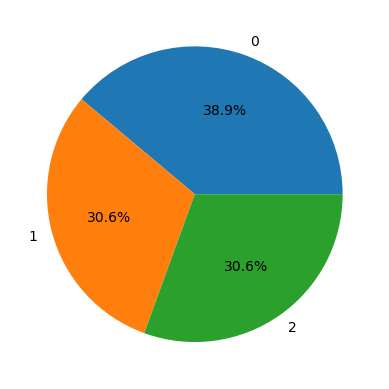

In [119]:
# визуализация распределения кластеров Kmeans
cluster_counts = dfHabr1['clustersKmeans'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

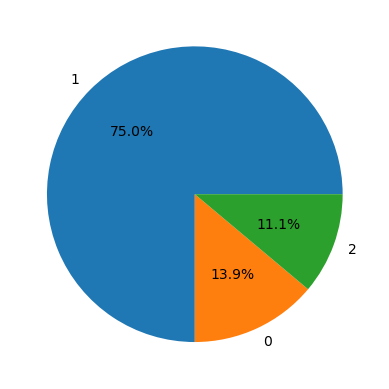

In [120]:
# визуализация распределения кластеров Spectral
cluster_counts = dfHabr1['clustersSpectral'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

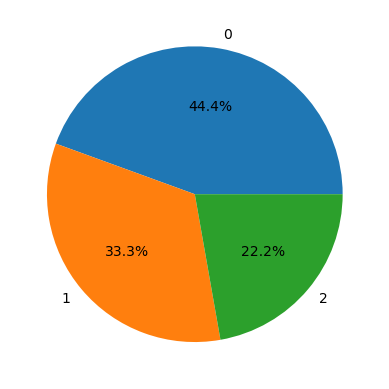

In [121]:
# визуализация распределения кластеров Agglomerative
cluster_counts = dfHabr1['clustersAgglomerative'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

#### Оценка качества кластеризации

In [122]:
a = (dfHabr1['clustersKmeans'] - dfHabr1['clustersKmeans'].mean()) / dfHabr1['clustersKmeans'].std()
a1 = (dfHabr1['clustersAgglomerative'] - dfHabr1['clustersAgglomerative'].mean()) / dfHabr1['clustersAgglomerative'].std()
a2 = (dfHabr1['clustersSpectral'] - dfHabr1['clustersSpectral'].mean()) / dfHabr1['clustersSpectral'].std()

In [123]:
data_norm_kmeans = a.values.reshape(-1, 1)
data_norm_agg = a1.values.reshape(-1, 1)
data_norm_spec = a2.values.reshape(-1, 1)

In [124]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_kmeans, km.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 1.0


In [125]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_agg, agg.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 1.0


In [126]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_spec, spectral.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 1.0


### 2.2 Тематическое моделирование

LDA - это метод машинного обучения, который используется для анализа тематической структуры в больших наборах документов. Который использует модель вероятности, чтобы определить, какие темы присутствуют в каждом документе, и какие слова связаны с каждой темой. LDA может быть полезен в случаях, когда нужно опредлить тематическую структуру в большом наборе документов, таких как статьи и т.д. 

In [127]:
# создание модели LDA
lda_model = LatentDirichletAllocation(n_components=10, random_state=0)
lda_model.fit(count_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(lda_model.components_):
    print(f"Topic {i}: {', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: нетология, год, аналитик, команда, рассказывать, обучение, разработчик, курс, приложение, задача
Topic 1: курс, нетология, преподаватель, программа преподаватель, программа, бесплатный, заявка, дашборда, самостоятельно, самостоятельно строить
Topic 2: задача, проект, команда, работа, тестирование, решение, обработка, процесс, человек, тестовый
Topic 3: команда, работа, работа команда, работать, конференция, задача команда, доклад, данные, начинать, год
Topic 4: разработчик, сбермаркет, задача, язык, митап, доклад, первый, системный, самый, тест
Topic 5: программа, бизнес, образование, работа, профессия, интенсив, цифровой, мочь, сентябрь, лекция
Topic 6: год, аналитик, нетология, обучение, продукт, компания, открытый, день, бизнес, сотрудник
Topic 7: рассказывать, решение, навык, код, год, кандидат, июнь, экран, навигация класс метод, навигация класс
Topic 8: команда, работа, нетология, сотрудник, бизнес, нетология распределнный помогать, сотрудник работать, сотрудник работать

In [128]:
print(str(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword']))

0     человек, язык, компьютерный, текст, лингвистик...
1     сервис, год, поездка, решение, клиент, каждый,...
3     команда, рассказывать, разработка, начинать, р...
6     год, иннотеха, компания, сотрудник, создавать,...
11    пользователь, продукт, интерфейс, работа, весь...
12    кандидат, человек, команда, давать, например, ...
13    задача, переподготовка, разработчик, язык, сбе...
14    компонент, внутри, сергей, нативный, проект, и...
15    рассказывать, ошибка, писать, поделиться, код,...
16    сбермаркет, приложение, разработчик, тест, рас...
17    разработчик, сбермаркет, митап, серия, доклад,...
18    приглашать, факап, офлайн, рассказывать, самый...
20    тест, юнит, код, проверять, функция, метод, об...
21    координатор, экран, навигация, класс, метод, р...
27    разработка, мобильный, занятие, платформа, при...
37    цифровой, год, профессия, компания, бизнес, ин...
Name: keyword, dtype: object


In [129]:
len(lda_model.components_)

10

In [130]:
lda_model.components_

array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [1.1, 1.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 1.1, 1.1, 1.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])

In [131]:
# создание матрицы документ-термин
tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(dfHabr2)

In [132]:
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

In [133]:
tfidf_matrix.shape

(36, 201)

NMF - это метод машинного обучения, который используется для разложения матрицы на две с неотрицательными элементами. Он может быть полезен в случаях, когда нужно найти скрытые признаки в данных, таких как тексты и т.д. NMF может использоваться в различных областях, таких как обработка изображений, текстовый анализ и т.д

In [134]:
# создание модели NMF
nmf_model = NMF(n_components=10, random_state=0)
nmf_model.fit(tfidf_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(nmf_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: работа, команда, конференция, сотрудник, задача, работать, помогать, распределнный, управление, нетология
Topic 1: системный, первый, аналитик, курс, нетология, интенсив, сентябрь, подойдт, открываться, июнь
Topic 2: разработка, разработчик, мобильный, начинать, приложение, хотеть, рассказывать, сегодня, платформа, сбермаркет
Topic 3: бизнес, год, компания, продукт, цифровой, среди, интернет, специалист, профессия, банковский
Topic 4: весь, сервис, решение, пользователь, делать, дизайнер, интерфейс, клиент, поездка, корпорация
Topic 5: код, метод, тест, тестировать, функция, юнит, тесто, объект, проверять, использовать
Topic 6: обучение, программа, преподаватель, нетология, курс, день, открытый, навык, слушатель, развивать
Topic 7: новый, данные, график, инструмент, дашборда, визуализация, строить, самостоятельно, интерактивный, курс
Topic 8: процесс, проект, тестовый, кандидат, команда, отслеживать, метрика, количество, кейс, качество
Topic 9: язык, сбермаркет, задача, челове

In [135]:
len(nmf_model.components_)

10

In [136]:

nmf_model.components_

array([[0.        , 0.        , 0.18199505, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.28642039, 0.48677952, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.09439568, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.06099879, ..., 0.        , 0.        ,
        0.        ],
       [0.04520653, 0.        , 0.08262457, ..., 0.        , 0.4024477 ,
        0.02205499]])

LSA - это метод машинного обучения, который используется для анализа структуры в больших наборах текстовых данных. Он использует матричные вычисления для определения близости между словами и документами. LSA может быть полезен в случаях, когда вы хотите определить структуру в большом наборе текстовых данных, таких как статьи, отчеты и т.д.

In [137]:
# создание модели LSA
lsa_model = TruncatedSVD(n_components=10, random_state=0)
lsa_model.fit(tfidf_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: команда, работа, нетология, задача, разработчик, проект, аналитик, год, сбермаркет, бизнес
Topic 1: нетология, курс, программа, обучение, преподаватель, бесплатный, аналитик, системный, первый, навык
Topic 2: разработчик, мобильный, разработка, митап, сбермаркет, рассказывать, тест, новый, хотеть, сентябрь
Topic 3: бизнес, год, цифровой, компания, продукт, сотрудник, образование, работа, весь, сервис
Topic 4: приложение, сервис, весь, разработка, решение, начинать, работа, код, проблема, инцидент
Topic 5: решение, код, продукт, обработка, тест, сервис, весь, доклад, январь, ошибка
Topic 6: сентябрь, первый, системный, интенсив, продукт, аналитик, хотеть, лекция, открываться, подойдт
Topic 7: новый, метод, сотрудник, код, приложение, бизнес, проект, использовать, роутер, навигация
Topic 8: проект, преподаватель, процесс, весь, сервис, сбермаркет, продукт, язык, вакансия, переподготовка
Topic 9: рассказывать, июнь, тестовый, процесс, тестирование, кейс, количество, метрика, каче

In [138]:
len(lsa_model.components_)

10

In [139]:
lsa_model.components_

array([[ 0.01789746,  0.04416284,  0.18539829, ...,  0.00709283,
         0.09788828,  0.0198797 ],
       [-0.01539048,  0.06235913,  0.12654656, ..., -0.01439841,
        -0.10632592, -0.02814139],
       [ 0.03022636, -0.01863638, -0.07691972, ...,  0.02960599,
         0.04381274,  0.02684552],
       ...,
       [-0.07380542, -0.03146716, -0.04664757, ...,  0.0926372 ,
        -0.08793956, -0.02451392],
       [-0.08834498, -0.0102488 , -0.06822369, ...,  0.00362973,
         0.10900498, -0.07537425],
       [ 0.05302028,  0.07111128,  0.03100305, ...,  0.03135581,
        -0.18468592,  0.01381285]])

В итоге лучшей моделью является LDA, т.к. она в данном случае самая нужная, и работает лучше всего (определяет тематическую структуру в большом наборе документов, таких как статьи и т.д.)

#### Визуализация тематического моделирования

In [140]:
pyLDAvis.enable_notebook()

In [141]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword'])

0     человек, язык, компьютерный, текст, лингвистик...
1     сервис, год, поездка, решение, клиент, каждый,...
3     команда, рассказывать, разработка, начинать, р...
6     год, иннотеха, компания, сотрудник, создавать,...
11    пользователь, продукт, интерфейс, работа, весь...
12    кандидат, человек, команда, давать, например, ...
13    задача, переподготовка, разработчик, язык, сбе...
14    компонент, внутри, сергей, нативный, проект, и...
15    рассказывать, ошибка, писать, поделиться, код,...
16    сбермаркет, приложение, разработчик, тест, рас...
17    разработчик, сбермаркет, митап, серия, доклад,...
18    приглашать, факап, офлайн, рассказывать, самый...
20    тест, юнит, код, проверять, функция, метод, об...
21    координатор, экран, навигация, класс, метод, р...
27    разработка, мобильный, занятие, платформа, при...
37    цифровой, год, профессия, компания, бизнес, ин...
Name: keyword, dtype: object


In [142]:
# визуализация модели LDA
panel = pyLDAvis.sklearn.prepare(lda_model, count_matrix, vectorizer, mds='tsne', sort_topics=False)
panel

C:\Users\essww\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0       5.250495  21.399397       1        1   0.357143
1     -16.590263  -3.283479       2        1  13.750000
2      24.301210  -4.895866       3        1  11.071431
3      -6.551036 -18.141394       4        1  11.071428
4      -3.178836   5.200213       5        1  11.071430
5      11.988324   5.914185       6        1  11.071428
6       5.002334  -7.494954       7        1   5.714288
7     -13.004671  17.127249       8        1  11.071427
8      24.043200  15.428759       9        1  16.428567
9      14.053029 -20.121536      10        1   8.392859, topic_info=                     Term      Freq     Total Category  logprob  loglift
481             программа  4.000000  4.000000  Default  30.0000  30.0000
540                работа  5.000000  5.000000  Default  29.0000  29.0000
632            сбермаркет  3.000000  3.000000  Default  28.0000  28.0000
120                задача  5.000000  5.000000  Default  27.0000  27.0000
29                 бизнес  3.000000  3.000000  Default  26.0000  26.0000
..                    ...       ...       ...      ...      ...      ...
287                 метод  0.554614  1.582801  Topic10  -4.9911   1.4291
770                хотеть  0.554614  1.582801  Topic10  -4.9911   1.4291
332  начинать разработчик  0.554614  1.582801  Topic10  -4.9911   1.4291
134               занятие  0.554614  1.582801  Topic10  -4.9911   1.4291
513                проект  0.554613  3.912097  Topic10  -4.9911   0.5242

[472 rows x 6 columns], token_table=      Topic      Freq                        Term
term                                             
5         4  0.263678                    аналитик
5         5  0.263678                    аналитик
5         8  0.263678                    аналитик
5         9  0.263678                    аналитик
5        10  0.263678                    аналитик
...     ...       ...                         ...
798       5  0.450737                        язык
799       3  0.927122           язык компьютерный
800       3  0.927122     язык компьютерный текст
801       5  0.927122         язык присоединяться
802       5  0.927122  язык присоединяться ноябрь

[434 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [143]:
# визуализация модели NMF
panel = pyLDAvis.sklearn.prepare(nmf_model, tfidf_matrix, tfidf_vectorizer, mds='tsne', sort_topics=False)
panel

C:\Users\essww\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\essww\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\essww\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0     -69.748367 -49.976738       1        1   8.839744
1      82.744064 -44.690559       2        1   9.601982
2     -76.567787  12.978433       3        1  11.745107
3     -21.527935  -7.114336       4        1  11.616808
4      23.110828  39.363544       5        1   7.285732
5      76.183861  18.314791       6        1   7.643057
6     -16.810358 -71.402000       7        1  14.640359
7      37.565762 -88.794640       8        1   6.147735
8      27.673367 -24.749380       9        1   9.145680
9     -31.172213  56.913841      10        1  13.333796, topic_info=            Term      Freq     Total Category  logprob  loglift
61          курс  1.000000  1.000000  Default  30.0000  30.0000
199         язык  1.000000  1.000000  Default  29.0000  29.0000
154       сервис  0.000000  0.000000  Default  28.0000  28.0000
10          весь  0.000000  0.000000  Default  27.0000  27.0000
136  разработчик  1.000000  1.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
17           год  0.299491  1.645104  Topic10  -3.9105   0.3114
52       команда  0.297620  1.729847  Topic10  -3.9168   0.2549
2       аналитик  0.224759  1.497803  Topic10  -4.1976   0.1181
125       проект  0.195754  1.384405  Topic10  -4.3357   0.0587
45      кандидат  0.154934  0.764933  Topic10  -4.5696   0.4181

[361 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2         2  0.667645       аналитик
7         4  0.689605         бизнес
10        5  1.179439           весь
17        4  0.607864            год
25        7  1.610516           день
27       10  1.103755         доклад
29       10  0.595583         задача
36        2  1.632991       интенсив
38        4  1.947931       интернет
45        9  1.307303       кандидат
50        6  1.356865            код
52        1  0.578086        команда
52        9  0.578086        команда
53        4  0.900842       компания
61        2  0.580461           курс
61        7  0.580461           курс
67        6  1.767734          метод
70        3  1.020056      мобильный
79        3  1.149473       начинать
80        2  0.513945      нетология
80        7  0.513945      нетология
82        8  0.864235          новый
86        7  0.829722       обучение
93        7  1.748275       открытый
98        2  1.190096         первый
111       7  1.049581  преподаватель
114       3  0.814902     приложение
119       7  0.732856      программа
122       4  0.752427        продукт
125       9  0.722332         проект
129       9  0.938287        процесс
130       1  0.706791         работа
135       3  0.810957     разработка
136       3  0.555864    разработчик
136      10  0.555864    разработчик
143       5  1.130776        решение
148      10  1.714280          самый
149      10  0.690901     сбермаркет
153       2  1.055775       сентябрь
154       5  1.179439         сервис
158       2  1.190096      системный
163       4  1.947931     специалист
164       4  1.947931          среди
172       6  1.129726           тест
177       9  1.228808       тестовый
193       4  1.274606       цифровой
195      10  1.308469        человек
199      10  0.913447           язык, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

К сожалению, модель LSA через pyLDAvis невозможно вывести

In [144]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword'])

0     человек, язык, компьютерный, текст, лингвистик...
1     сервис, год, поездка, решение, клиент, каждый,...
3     команда, рассказывать, разработка, начинать, р...
6     год, иннотеха, компания, сотрудник, создавать,...
11    пользователь, продукт, интерфейс, работа, весь...
12    кандидат, человек, команда, давать, например, ...
13    задача, переподготовка, разработчик, язык, сбе...
14    компонент, внутри, сергей, нативный, проект, и...
15    рассказывать, ошибка, писать, поделиться, код,...
16    сбермаркет, приложение, разработчик, тест, рас...
17    разработчик, сбермаркет, митап, серия, доклад,...
18    приглашать, факап, офлайн, рассказывать, самый...
20    тест, юнит, код, проверять, функция, метод, об...
21    координатор, экран, навигация, класс, метод, р...
27    разработка, мобильный, занятие, платформа, при...
37    цифровой, год, профессия, компания, бизнес, ин...
Name: keyword, dtype: object


#### Распределение кластеров по тематическому моделированию

In [155]:
# Массив, в котором будут сохраняться перебранные lda компоненты
topics = []

for i, topic in enumerate(lda_model.components_):
    # топ векторизованных слов
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
    topic_string = f"Topic {i}: {', '.join(top_words)}"
    # добавление
    topics.append(topic_string)

In [156]:
dfCosinTest = pd.DataFrame({'texts': topics})

In [157]:
dfj = {'texts': [], 'cos_similarities' : [], 'cluster': []}

In [158]:
# цикл, который реализует сравнение топ слов lda модели и кластеров, для правильного подбора кластера к lda модели
for i in range(0, 3):
    # выбор текста - цели
    find_nearest_to = str(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == i, 'keyword'])
    # формирование весов tf-idf
    tfidf = TfidfVectorizer()
    mx_tf = tfidf.fit_transform(topics)
    new_entry = tfidf.transform([find_nearest_to])
    sdf = pd.DataFrame.sparse.from_spmatrix(mx_tf)
    new_entry = tfidf.transform([find_nearest_to])
    pd.DataFrame.sparse.from_spmatrix(new_entry)
    # создание косинуснового сходства
    cosine_similarities = cosine_similarity(new_entry, mx_tf).flatten()
    dfCosinTest['cos_similarities'] = cosine_similarities
    # сортировка, для выбора наибольшего сходства
    dfCosinTest = dfCosinTest.sort_values(by=['cos_similarities'], ascending=[0])
    dfCosinTest = dfCosinTest.reset_index(drop=True)
    dfj['texts'].append(dfCosinTest['texts'][0])
    dfj['cos_similarities'].append(dfCosinTest['cos_similarities'][0])
    dfj['cluster'].append(i)

In [159]:
dfClusters = pd.DataFrame(data = dfj)

In [160]:
dfClusters.head(15)

,texts,cos_similarities,cluster
0,"Topic 4: разработчик, сбермаркет, задача, язык...",0.453643,0
1,"Topic 4: разработчик, сбермаркет, задача, язык...",0.436767,1
2,"Topic 2: задача, проект, команда, работа, тест...",0.683123,2


Наука, технологии и инновации: Gett, Иннотех

Номинация “Экономика и бизнес”: СберМаркет

Номинация “Образование и Кадры”: Нетология

### 2.4 Разведочный анализ

C:\Users\essww\AppData\Local\Temp\ipykernel_7384\785557542.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dfHabr1['clustersAgglomerative'], shade=True)


<module 'matplotlib.pyplot' from 'C:\\Users\\essww\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

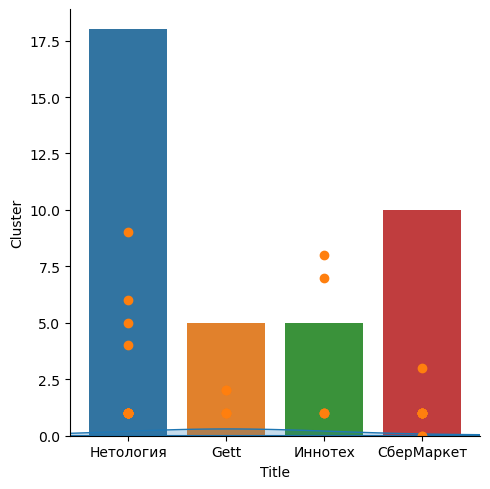

In [72]:
sns.catplot(x='TitleCompany', kind='count', data=dfHabr1)
# анализ плотности распределения целевой переменной
sns.kdeplot(dfHabr1['clustersAgglomerative'], shade=True)
# визуализация зависимости кластеров от временных признаков
plt.scatter(dfHabr1['TitleCompany'], dfHabr1['clustersAgglomerative'])
plt.xlabel('Title')
plt.ylabel('Cluster')
plt 

In [118]:
# сохраняем DataFrame в файл
dfHabr1.to_csv(r'Downloads\Report2.csv', index=False, encoding='utf-8')

### 2.5 Подготовка отчета




__2.1 Поиск ключевых слов/n-грамм. Векторизация текста__ Пункт был выполнен без нареканий. Биграммы, триграммы и векторизация выполнены успешно.

__2.2 Тематическое моделирование__ Сначала была выполнена кластеризация, потом тематическое моделирование. Само тематическое моделирование было выполнено тремя способами LDA, NMF и LSA, оно прошло успешно и была выбрана LDA.

    __2.2.1 LDA__ (лучшая модель) выбрал потому, что он может быть полезен в случаях, когда нужно опредлить тематическую структуру в большом наборе документов, таких как статьи и т.д. 

    __2.2.2 NMF__ выбрал потому, что он может быть полезен в случаях, когда нужно найти скрытые признаки в данных, таких как тексты и т.д.

    __2.2.3 LSA__ выбрал потому, что он может быть полезен в случаях, когда нужно определить структуру в большом наборе текстовых данных, таких как статьи, отчеты и т.д.


__2.3 Кластеризация__ Предварительная обработка данных выполнена без проблем. Кластеры показали себя одинакого, по сравнению друг с другом из-за того, что текста довольно разные и их мало, оценка кластеризации не сработало из-за маленького количества строк, в соответствии кластеров.

    __2.3.1 Agglomerative__ выбрал потому, что он полезен в случаях, когда нужно разбить данные на группы на основе их сходства.

    __2.3.2 Kmeans__ выбрал потому, что он полезен в случаях, когда нужно разбить данные на группы на основе их сходства.

    __2.3.3 Spectral__ выбрал потому, что он полезен в случаях, когда нужно разбить данные на группы на основе их сходства, но данные не могут быть разделены на группы в исходном пространстве признаков.

__2.4 Разведочный анализ__ Предварительная обработка данных выполнена полностью, без проблем.

### Вывод

В итоге датафрейм почти полностью готов к 3-ей Сессии. Но есть небольшие недочеты, по типу того, что датасет очень маленький. И проблемы связанные с этим. Такие как проблема с кластеризацией.

